In [190]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [191]:
with open('testSlice.json') as json_file:
    slices = json.load(json_file)

In [192]:
class Stmt_Expression():
    def __init__(self, expr):
        self.expr = expr
    
    def __repr__(self):
        return f"Stmt_Expression({self.expr})"

class Expr_Assign():
    def __init__(self, var, expr):
        self.var = var
        self.expr = expr
    def __repr__(self):
        return f"Assignment({self.var}={self.expr})"

class Expr_FuncCall():
    def __init__(self, name, args):
        self.name = name
        self.args = args
    def __repr__(self):
        return f"FuncCall(name={self.name},args={self.args})"

class Expr_Variable():
    def __init__(self, name):
        self.name = name
    def __repr__(self):
        return f"Variable({self.name})"
    def __eq__(self, other):
        # Check if the other object is an Assignment and has the same left and right values
        if isinstance(other, Expr_Variable) and self.name == other.name:
            return True
        return False
    def __hash__(self):
        # Return a unique and immutable value based on the left and right values
        return hash(self.name)

class Constant():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Constant(value={self.value})"

class Program():
    def __init__(self, steps):
        self.steps = steps

    def __repr__(self):
        steps_str = '\n'.join(f'\t{idx}. {step}' for idx, step in enumerate(self.steps))
        return f'Program(\n{steps_str}\n)'

In [195]:
def process_json(obj):
    if isinstance(obj, dict):
        if obj["nodeType"] == 'Stmt_Expression':
            #expr = process_json(obj["expr"])
            #return Stmt_Expression(expr)
            return process_json(obj["expr"])
        if obj["nodeType"] == "Expr_Assign":
            var = process_json(obj["var"])
            expr = process_json(obj["expr"])
            return Expr_Assign(var, expr)
        if obj["nodeType"] == "Expr_FuncCall":
            name = obj["name"]["parts"][0]
            args = [process_json(arg) for arg in obj["args"]]
            return Expr_FuncCall(name, args)
        if obj["nodeType"] == "Arg":
            return process_json(obj["value"])
        if obj["nodeType"] == "Expr_Variable":
            return Expr_Variable(obj["name"])
        if obj["nodeType"] == "Scalar_String":
            return Constant(obj["value"])
    elif isinstance(obj, list):
        #for item in obj:
        steps = [process_json(step) for step in obj][:-1]
        return Program(steps)
    else:
        # obj is a scalar value (int, float, string, etc.)
        print(obj)

# Process the JSON object
parsed_ast = process_json(slices)

In [196]:
print(parsed_ast)

Program(
	0. Assignment(Variable(a)=Constant(value=))
	1. Assignment(Variable(a)=FuncCall(name=b,args=[]))
	2. Assignment(Variable(c)=Variable(a))
	3. Assignment(Variable(d)=Variable(c))
	4. FuncCall(name=e,args=[Variable(d)])
	5. Assignment(Variable(c)=Constant(value=))
)


In [197]:
# Function to recursively find all assignments in the AST
def find_assignments(node, graph):
    if isinstance(node, Expr_Assign):
        if graph.has_node(node.var):
            # If the value of a varaible is overwritten before it is referenced anywhere
            if len(list(graph.successors(node.var))) == 0:
                for u, v in list(graph.in_edges(node.var)):
                    graph.remove_edge(u, v)
                    graph.remove_node(u)

        # Add an edge to the graph for the assignment
        graph.add_edge(node.expr, node.var)
    if isinstance(node, Expr_FuncCall):
        # Add an edge to the graph for the assignment
        #print(node.expr)
        for arg in node.args:
            graph.add_edge(arg, node)
    # Recurse on children
    if hasattr(node, 'steps'):
        for step in node.steps:
            find_assignments(step, graph)

# Create an empty graph
graph = nx.DiGraph()

# Find all assignments in the AST and add them to the graph
find_assignments(parsed_ast, graph)

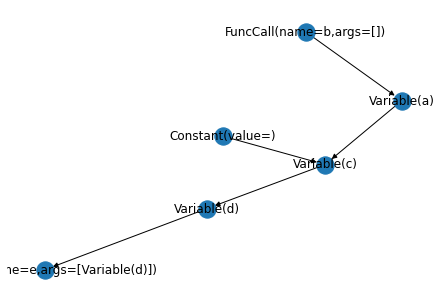

In [198]:
# Use NetworkX's draw() function to draw the graph
nx.draw(graph, with_labels=True)

# Display the graph
plt.show()